# SCSolver : outil pour gagner à Saute-Canton

On commence par les imports

In [1]:
from collections import deque
import pandas as pd
import geopandas as geo
import folium
from folium.plugins import AntPath

import importlib
selenium = importlib.util.find_spec('selenium') is not None

Exceptions pour gérer les homonymes/erreurs

In [2]:
class VilleNotFound(Exception):
    pass


class VilleMultiples(Exception):
    pass

## Chargement des données

On charge les données INSEE pour avoir les populations

In [3]:
with open('ensemble.xls', 'rb') as ensemble:
    data_villes = pd.read_excel(ensemble, 4, header=7,
                                dtype={0: int, 3: int, 5: int, 7: int, 8: int, 9: int,
                                       1: str, 2: str, 4: str, 6: str})
    data_villes['code_insee'] = data_villes['Code département'] + data_villes['Code commune'].apply(
        lambda x: '{:03d}'.format(x))
    data_villes.set_index('code_insee', inplace=True)

On charge les adjacences entre villes

In [4]:
with open('adjacences.csv', 'r') as adjacence:
    pre_data_adj = pd.read_csv(adjacence)

On charge les données de géolocalisation

In [5]:
geodata = geo.read_file('communes-20200101.shp')
#geodata = geo.read_file('communes-20190101.json')
geodata.set_index('insee', inplace=True)
geodata.crs = "EPSG:4326"

On construit la matrice d'adjacence sous forme de dict

In [6]:
adj_matrix = {}
for index, row in pre_data_adj.iterrows():
    voisins = []
    liste_v = row['insee_voisins'].split('|')
    liste_cap = row['as$'].split('|')
    for i in range(row['nb_voisins']):
        voisins.append({'id': liste_v[i], 'cap': liste_cap[i]})
    adj_matrix[row['insee']] = voisins

Pour trouver le plus court chemin (en nombre de sauts) : un BFS

In [7]:
def bfs(init, data_villes, adj_matrix, pop=50000, toutes_solutions=False):
    # Pour trouver le plus court chemin (en nombre de sauts) : un BFS
    visited = {}
    solutions = []
    distance = 36000
    queue = deque()
    depart = init
    for v in adj_matrix[depart]:
        queue.appendleft([v])
    while len(queue) > 0:
        chemin = queue.pop()
        ville = chemin[-1]
        if ville['id'] not in visited and len(chemin) <= distance:
            try:
                voisin = data_villes.loc[ville['id']]
                if voisin['Population totale'] >= pop:
                    if toutes_solutions:
                        solutions.append(chemin)
                        distance = len(chemin)
                    else:
                        return [chemin]
                for v in adj_matrix[ville['id']]:
                    prochain = chemin[:]
                    prochain.append(v)
                    queue.appendleft(prochain)
            except KeyError:
                pass
            visited[ville['id']] = 1
    return solutions

Utilitaire pour vérifier d'où on part.

In [8]:
def check_ville(ville, data_villes):
    c = data_villes.loc[data_villes['Nom de la commune'] == ville].shape[0]
    if c == 0:
        raise VilleNotFound("Ville introuvable")
    if c > 1:
        raise VilleMultiples(
            "Plusieurs villes (" + str(c) + ") trouvées, précisez la recherche avec l'option -n VILLE_VOISINE")

## Résolution

On a comme paramètres :

 - **depart** : la ville d'où le joueur part
 - **population_cible** : la taille de ville qu'on vise
 - **toutes_solution** : est-ce que l'on veut afficher tous les chemins les plus courts ou juste le premier
 - **voisin** : le nom d'une commune voisine en cas d'homonymes au départ
 - **exportable** : si Selenium est installé avec Firefox, tente de générer une image PNG pour imprimer/exporter le notebook

In [9]:
depart = 'Morangis'
population_cible = 50000
toutes_solutions = True
voisin = None
exportable = True

On initialise la liste des villes déjà vues

In [10]:
liste_id_start = []
try:
    check_ville(depart, data_villes)
    liste_id_start.append(data_villes.loc[data_villes['Nom de la commune'] == depart].index.values[0])
except VilleMultiples:
    if voisin is not None:
        check_ville(voisin, data_villes)
        id_voisin_pot = data_villes.loc[data_villes['Nom de la commune'] == voisin].index.values[0]
        for potentiel in adj_matrix[id_voisin_pot]:
            ville_pot = data_villes.loc[potentiel['id']]
            if ville_pot['Nom de la commune'] == depart:
                liste_id_start.append(potentiel['id'])
        if len(liste_id_start) == 0:
            raise VilleNotFound("Villes non voisines")
    else:
        liste = data_villes.loc[data_villes['Nom de la commune'] == depart]
        for ville_pot in liste.iterrows():
            liste_id_start.append(ville_pot[0])

On résoud

In [11]:
solutions = []
for id_start in liste_id_start:
    chemins = bfs(id_start, data_villes, adj_matrix, population_cible, toutes_solutions)
    g_start = geodata.loc[id_start]['geometry']
    p_start = g_start.centroid
    solution = {'start': g_start, 'chemins' : chemins}
    solution['ants'] = []
    # On construit le chemin
    chem_str_tab = []
    for chemin in chemins:
        chem_str = depart
        ants = [[p_start.y, p_start.x]]
        for ville in chemin:
            id = ville['id']
            g = geodata.loc[id]['geometry']
            p = g.centroid
            ants.append([p.y, p.x])
            data = data_villes.loc[id]
            nom = data['Nom de la commune']
            chem_str += '->' + nom
        chem_str_tab.append(chem_str)
        solution['ants'].append(ants)
    solutions.append(solution)
    # Et le chemin solution est :
    for chem in chem_str_tab:
        print(chem)

Morangis->Chavot-Courcourt->Moussy->Épernay->Hautvillers->Saint-Imoges->Sermiers->Villers-aux-Nœuds->Reims
Morangis->Chilly-Mazarin->Massy
Morangis->Wissous->Antony


On va maintenant dessiner et afficher le chemin.

On commence par centre la carte sur le départ.

In [12]:
g_start = geo.GeoSeries([x['start'] for x in solutions])
p_start = g_start.centroid
x_start = (min(p.x for p in p_start) + max(p.x for p in p_start))/2
y_start = (min(p.y for p in p_start) + max(p.y for p in p_start))/2
low_bound_y = min(p.y for p in p_start)
upp_bound_y = max(p.y for p in p_start)
low_bound_x = min(p.x for p in p_start)
upp_bound_x = max(p.x for p in p_start)

In [13]:
m = folium.Map(location=[y_start, x_start], png_enabled=selenium and exportable)

In [14]:
for solution in solutions:
    p_start = solution['start'].centroid
    low_bound_y = min(low_bound_y, p_start.y)
    upp_bound_y = max(upp_bound_y, p_start.y)
    low_bound_x = min(low_bound_x, p_start.x)
    upp_bound_x = max(upp_bound_x, p_start.x)
    _ = folium.Marker(location=[p_start.y, p_start.x],popup=depart,icon=folium.Icon(color='green')).add_to(m)
    _ = folium.GeoJson(solution['start'],name=depart).add_to(m)

On construit les chemins

In [15]:
couleurs = ['red', 'blue', 'orange', 'pink', 'cadetblue', 'purple', 'gray']
for solution in solutions:
    c_ind=0
    i=0
    for chemin in solution['chemins']:
        for ville in chemin:
            id = ville['id']
            g = geodata.loc[id]['geometry']
            p = g.centroid
            low_bound_y = min(low_bound_y, p.y)
            upp_bound_y = max(upp_bound_y, p.y)
            low_bound_x = min(low_bound_x, p.x)
            upp_bound_x = max(upp_bound_x, p.x)
            data = data_villes.loc[id]
            nom = data['Nom de la commune']
            folium.GeoJson(g,name=nom).add_to(m)
        folium.Marker(location=[p.y, p.x],popup=nom,icon=folium.Icon(color=couleurs[c_ind])).add_to(m)
        antpath = AntPath(locations=solution['ants'][i], color=couleurs[c_ind])
        antpath.add_to(m)
        c_ind = (c_ind + 1) % len(couleurs)
        i+=1
m.fit_bounds([[low_bound_y, low_bound_x],[upp_bound_y, upp_bound_x]])

On affiche la carte

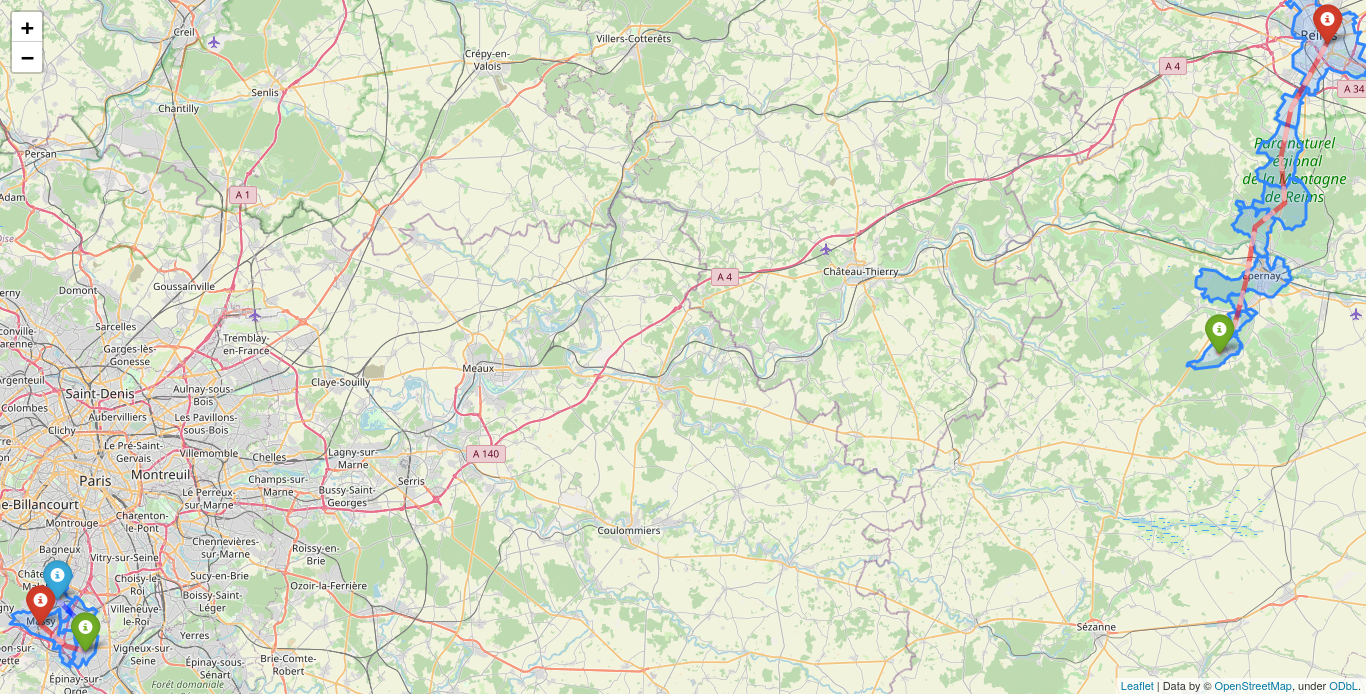

In [16]:
m